# Milgadara Case Study 2.0

### Goal:
Demonstrating PaddockTS -> DAESIM using annotated, paddock-level crop type and yield data from Milgadara

### Inputs:
#### Time series satellite data from Sentinel-2 
- annotated paddock boundaries (.gpkg)
    - the field 'name' must be unique
- annotated paddock-year table. (.csv)
    - field 'name' must link to paddock boundaries.
    - Other fields include: crop type, yield, treatments, dates (sow, harvest, observed flower, etc.)
- auto-generated paddock boundaries, produced using SAMGeo (*.csv)
- xarray object with 10m resolution reflectance data from 2018-2024 including derived indices and veg frac proportions (LARGE file ~70GB?)
- xarray object with paddock-level summaries of time series.
    - two versions, produced either using annotated and autogenerated paddock boundaries.
    - 

### Outputs:
1. Map of property with manual paddocks overlaid.
2. Show a summary table of the paddock annotation data.
4. RGB and veg frac time lapse with paddocks overlaid.
    - impute or not?
    - this can be hard to show in a saved ipynb because the video is a large file
5. false colour image showing the Fourrier transform from NDWI time series.
6. Map of SAMGeo paddocks next to manual paddocks, showing labels for each.
7. Function to create "calendar plots" given list of paddock names for either the manual or auto-generated paddocks.
8. 


#### Below are run settings for testrun.sh on Dec 10 2025.
- This is an incomplete version of the automated pipeline, which gets most of the way towards the automated outputs.
- By running this first, we prepared some of the (automated) processed inputs for this case study that can simply be read in for this notebook.
- A key step that was not in pipeline at the time is to make the paddock-level time series... This is run in final_steps_paddockTS.ipynb but will be included in the pipeline. 

### Setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import rasterio #
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib
import rioxarray
from shapely.geometry import mapping

import pickle
import os
import shutil



In [4]:
outdir = "/g/data/xe2/jb5097/PaddockTS_Results/"

# ID for PaddockTS run:
#stub = "MILGADARA_b03_2018-2024"
stub = "MILG_b01_2018-2024" # this is a smaller version that could be useful for testing and was already run before today.. 

## Paths of files generated by paddockTS pipeline
# tifs showing paddock maps overlaid on rgb and ft image
rgb_path = outdir + stub + "_paddock_map_auto_rgb.tif"
fourier_path = outdir + stub + "_paddock_map_auto_fourier.tif"

## Paths of manually curated data for this case study
paddocks_manual = "/g/data/xe2/John/Data/PadSeg/milg_manualpaddocks2.gpkg" # hand-drawn paddock polygons with name column that MAY match with annotation data (not all rows will have annotations)
paddock_annotations = "/g/data/xe2/John/Data/PadSeg/paddock-year-yield.csv" # paddock management annotation data (Format is to be changed to Agriweb .json in future version)


In [34]:
# Read in the hand-drawn paddocks and check them out on a map
polm = gpd.read_file(paddocks_manual)
polm = polm[polm["type"].eq("named")]
print(polm)

                    name   type  \
37                  No 1  named   
38                  Tank  named   
39         Ranch Paddock  named   
40                  No 2  named   
41                  No 3  named   
42                  No 4  named   
43             Pine Hill  named   
45           Little Tank  named   
46        Old Sheep Yard  named   
47              135 Acre  named   
48     Horse Paddock Big  named   
49  Little Horse Paddock  named   
50        Centre Paddock  named   
51             Air Strip  named   
52                 Rocky  named   
53            Rocky East  named   
54      Scramble Paddock  named   
55         Washpool East  named   
56          Bottom Range  named   
57           Rocky South  named   
58              Washpool  named   
59       Rubbish Paddock  named   
60               Contour  named   
61           Fingerboard  named   
62              Johnny's  named   

                                             geometry  
37  POLYGON ((14325453.541 -41324

In [10]:
# Read in the polygons from SAMGeo (these will not neccesarily match user-provided paddocks)
pol = gpd.read_file(outdir+stub+'_filt.gpkg')
# have to set a paddock id. Preferably do this in earlier step in future... 
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
pol.head()

,area_ha,log_area_ha,perim-area,geometry,paddock
0,59.5,1.774517,22.857143,"POLYGON ((14324740.000 -4133970.000, 14325190....",1
1,43.9,1.642465,26.879271,"POLYGON ((14324350.000 -4133970.000, 14324350....",2
2,112.5,2.051153,15.466667,"POLYGON ((14324090.000 -4133970.000, 14324310....",3
3,17.5,1.243038,33.142857,"POLYGON ((14325770.000 -4134180.000, 14325810....",4
4,22.8,1.357935,31.578947,"POLYGON ((14324990.000 -4134250.000, 14325010....",5


In [11]:
# Read in the time series reflectance data with indices and veg frac
with open(outdir+stub+'_ds2i.pkl', 'rb') as handle:
    ds = pickle.load(handle)
ds

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 510, y: 213, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
  * y                 (y) float64 2kB -4.134e+06 -4.134e+06 ... -4.136e+06
  * x                 (x) float64 2kB 1.432e+07 1.432e+07 ... 1.433e+07
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 84MB 710.0 706.0 ... 507.0 510.0
    nbart_green       (time, y, x) float32 84MB 965.0 933.0 ... 782.0 785.0
    nbart_red         (time, y, x) float32 84MB 1.25e+03 1.245e+03 ... 727.0
    nbart_red_edge_1  (time, y, x) float32 84MB 1.438e+03 ... 1.244e+03
    nbart_red_edge_2  (time, y, x) float32 84MB 1.633e+03 ... 2.401e+03
    nbart_red_edge_3  (time, y, x) float32 84MB 1.831e+03 ... 2.983e+03
    ...                ...
    bg                (time, y, x) float64 169MB 0.1091 0.1038 ... 0.1235 0.1304
    pv                (time, y, x) float64 169MB 0.08001 0.06557 ... 0.7469
    npv               (time, y, x) float64 169MB 0.8085 0.8288 ... 0.1312 0.1234
    NDVI              (time, y, x) float32 84MB 0.232 0.2265 ... 0.6327 0.6346
    CFI               (time, y, x) float32 84MB 572.9 544.7 ... 1.134e+03
    NIRv              (time, y, x) float32 84MB 465.1 447.0 ... 2.064e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [17]:
### Read in the paddock-year annotation data
# This requires some cleanup taken care of in the following function
# Changing the format of the .csv will change requirements here. take note when adjusting pipeline to use Agriweb data... 

import pandas as pd

def clean_paddock_year_df(df: pd.DataFrame) -> pd.DataFrame:
    # Drop rows where 'Year' is NaN and copy to avoid chained assignment issues
    df_clean = df.dropna(subset=['Year']).copy()
    
    # Keep the required columns and rename 'Yield_actuals' to 'Yield'
    df_clean = df_clean[['Year', 'Paddock', 'Crop', 'ha', 'Yield_actuals']].rename(
        columns={'Yield_actuals': 'Yield'}
    )

    # Convert 'Year' to integer year (handles strings like "2020" as well)
    df_clean['Year'] = pd.to_datetime(df_clean['Year'], format='%Y').dt.year

    # Convert 'Paddock' and 'Crop' to categorical types
    df_clean['Paddock'] = df_clean['Paddock'].astype('category')
    df_clean['Crop'] = df_clean['Crop'].astype('category')
    
    # Convert 'ha' to integer
    df_clean['ha'] = df_clean['ha'].astype('int')

    # Clean and convert 'Yield' to numeric:
    #  - cast to string
    #  - strip whitespace
    #  - turn empty strings into NA
    #  - then to numeric with errors coerced to NaN
    df_clean['Yield'] = (
        df_clean['Yield']
        .astype(str)
        .str.strip()
        .replace({"": pd.NA})
    )
    df_clean['Yield'] = pd.to_numeric(df_clean['Yield'], errors='coerce')

    # Optionally drop rows where 'Yield' is NaN or 0
    # df_clean = df_clean.dropna(subset=['Yield'])
    # df_clean = df_clean[df_clean['Yield'] != 0]

    return df_clean

In [20]:
pad_year = clean_paddock_year_df(pd.read_csv(paddock_annotations))
pad_year.head()

,Year,Paddock,Crop,ha,Yield
0,2018,Rocky East,Oats,42,2.0
1,2018,Rocky,Canola,60,0.6
2,2018,Rocky South,Wheat,40,0.9
3,2018,Rubbish Paddock,Oats U/S,30,1.4
4,2018,Air Strip,Oats U/S,30,1.4


/g/data/xe2/John/geospatenv/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


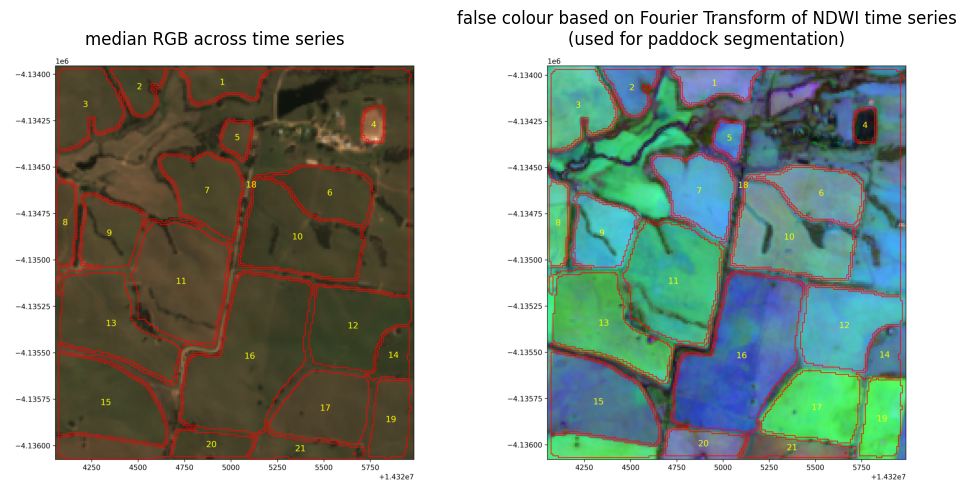

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File paths
rgb_path = outdir + stub + "_paddock_map_auto_rgb.tif"
fourier_path = outdir + stub + "_paddock_map_auto_fourier.tif"

# --- Read RGB image ---
with rasterio.open(rgb_path) as src:
    rgb = src.read()            # (bands, H, W)
rgb = np.moveaxis(rgb, 0, -1)   # → (H, W, 3) for imshow

# --- Read Fourier-based image ---
with rasterio.open(fourier_path) as src:
    fourier = src.read()
if fourier.shape[0] > 1:
    fourier = np.moveaxis(fourier, 0, -1)   # for multiband
else:
    fourier = fourier[0]                   # single-band → 2D

# --- Plot side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("median RGB across time series")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fourier)
plt.title("false colour based on Fourier Transform of NDWI time series\n(used for paddock segmentation)")
plt.axis("off")

plt.tight_layout()
plt.show()


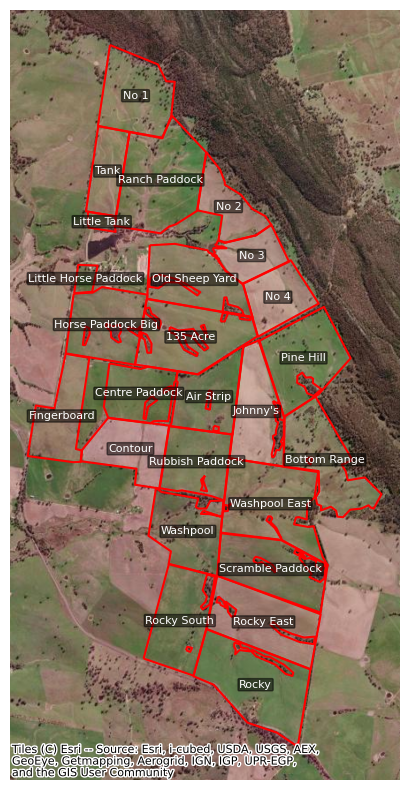

Plotted named paddocks: ['No 1', 'Tank', 'Ranch Paddock', 'No 2', 'No 3', 'No 4', 'Pine Hill', 'Little Tank', 'Old Sheep Yard', '135 Acre', 'Horse Paddock Big', 'Little Horse Paddock', 'Centre Paddock', 'Air Strip', 'Rocky', 'Rocky East', 'Scramble Paddock', 'Washpool East', 'Bottom Range', 'Rocky South', 'Washpool', 'Rubbish Paddock', 'Contour', 'Fingerboard', "Johnny's"]


In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read in the hand-drawn paddocks and keep only named ones
polm = gpd.read_file(paddocks_manual)
polm = polm[polm["type"].eq("named")].copy()

# Reproject to Web Mercator (needed for web tile basemaps)
polm_web = polm.to_crs(epsg=3857)

# Make the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot paddock polygons
polm_web.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=1.5,
)

# Add labels at polygon centroids
for _, row in polm_web.iterrows():
    c = row.geometry.centroid
    ax.text(
        c.x,
        c.y,
        str(row["name"]),
        fontsize=8,
        color="white",
        ha="center",
        va="center",
        bbox=dict(
            facecolor="black",
            alpha=0.5,
            boxstyle="round,pad=0.1"
        ),
    )

# Add a nice basemap (Esri World Imagery = aerial/satellite)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

# Optional: see which paddocks were plotted
print("Plotted named paddocks:", polm["name"].tolist())



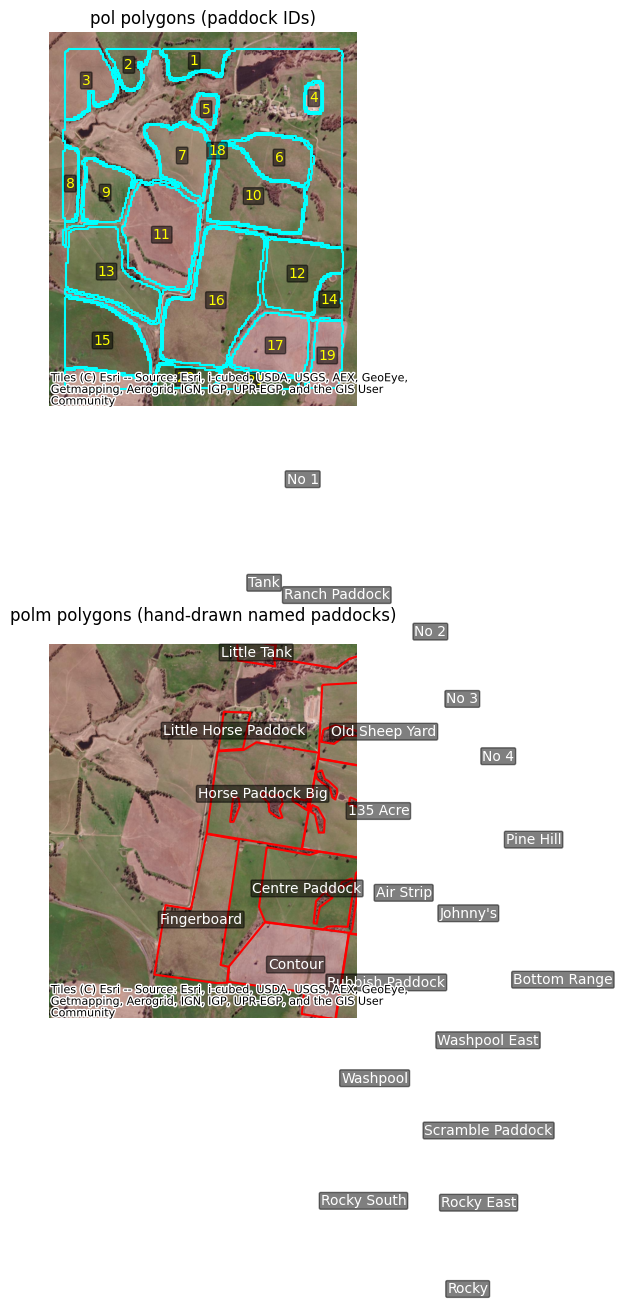

In [40]:
import matplotlib.pyplot as plt
import contextily as ctx

# Reproject both to Web Mercator (required for basemap)
pol_web = pol.to_crs(epsg=3857)
polm_web = polm.to_crs(epsg=3857)

# --- Create figure with two stacked panels ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))  # tall figure

# ============================================================
# 1) TOP PLOT: pol polygons, labeled by 'paddock'
# ============================================================
pol_web.plot(
    ax=ax1,
    facecolor="none",
    edgecolor="cyan",
    linewidth=1.5,
)

# Add labels
for _, row in pol_web.iterrows():
    c = row.geometry.centroid
    ax1.text(
        c.x, c.y,
        str(row["paddock"]),
        fontsize=10,
        color="yellow",
        ha="center",
        va="center",
        bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.1")
    )

ax1.set_title("pol polygons (paddock IDs)")
ax1.set_axis_off()

# Add imagery
ctx.add_basemap(ax1, source=ctx.providers.Esri.WorldImagery)

# Save extent for bottom map
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()


# ============================================================
# 2) BOTTOM PLOT: polm polygons, labeled by 'name'
# ============================================================
polm_web.plot(
    ax=ax2,
    facecolor="none",
    edgecolor="red",
    linewidth=1.5,
)

# Add labels
for _, row in polm_web.iterrows():
    c = row.geometry.centroid
    ax2.text(
        c.x, c.y,
        str(row["name"]),
        fontsize=10,
        color="white",
        ha="center",
        va="center",
        bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.1")
    )

ax2.set_title("polm polygons (hand-drawn named paddocks)")
ax2.set_axis_off()

# Use the exact same extent as the top map
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# Add basemap
ctx.add_basemap(ax2, source=ctx.providers.Esri.WorldImagery)

plt.tight_layout()
plt.show()

